[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/tumor-segmentation.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from skimage.transform import rescale, resize

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd'] # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [3]:
# Problem setup
n=500 # number of calibration points
alpha = 0.1 # 1-alpha is the desired false negative rate

def false_negative_rate(pred_masks, true_masks):
    return 1-((pred_masks * true_masks).sum(axis=1).sum(axis=1)/true_masks.sum(axis=1).sum(axis=1)).mean()

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = sgmd[idx,:], sgmd[~idx,:]
cal_gt_masks, val_gt_masks = gt_masks[idx], gt_masks[~idx]

### Conformal risk control happens here

In [5]:
# Run the conformal risk control procedure
def lamhat_threshold(lam): return false_negative_rate(cal_sgmd>=lam, cal_gt_masks) - ((n+1)/n*alpha - 1/(n+1))
lamhat = brentq(lamhat_threshold, 0, 1)
predicted_masks = val_sgmd >= lamhat

In [6]:
# Calculate empirical FNR
print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

The empirical FNR is: 0.10833496866080039 and the threshold value is: 0.46211493015381133


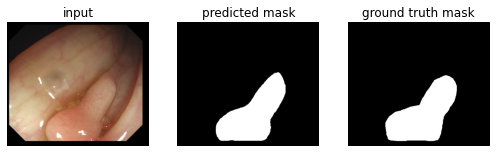

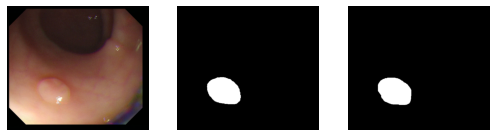

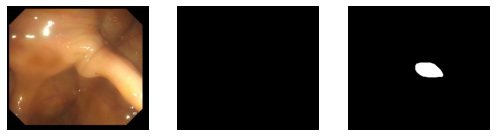

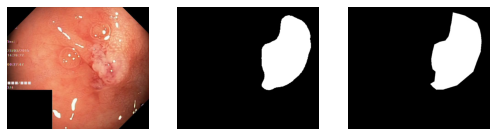

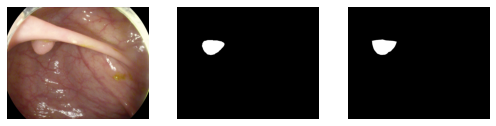

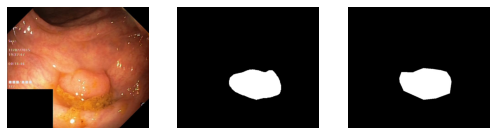

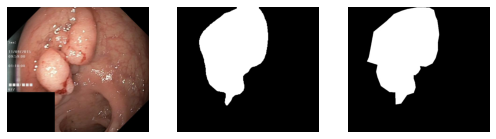

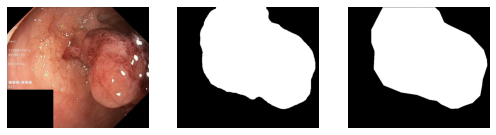

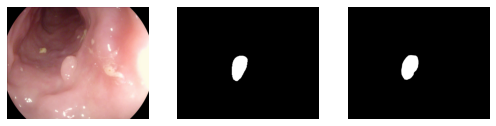

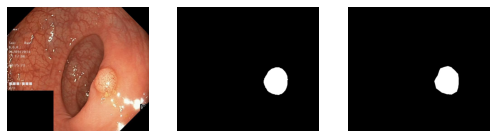

In [7]:
# Show some examples
for i in range(10):
    rand_idx = np.random.choice(example_indexes)
    img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
    gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
    predicted_mask = resize(sgmd[rand_idx] > 1-lamhat, (img.shape[0],img.shape[1]), anti_aliasing=False)
    fig, axs = plt.subplots(1,3,figsize=(8.64,4.76))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')
    if i == 0:
        axs[0].set_title('input')
        axs[1].set_title('predicted mask')
        axs[2].set_title('ground truth mask')
    plt.show()

This method was first introduced here: https://arxiv.org/abs/2208.02814.